In [1]:
import os
from copy import deepcopy
from collections import OrderedDict
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from hdf5storage import loadmat, savemat

import pycochleagram.cochleagram as cgram

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import DynamicModel, NcvContinuous
from pyro.contrib.tracking.measurements import PositionMeasurement

pyro.enable_validation(True)
pyro.clear_param_store()

from tools.experiment_neural import stim_tr, stim_vl, data_tr, data_vl, stim_tx, data_tx
from tools.data_librispeech import LibriDataset, load_subset, cgram_params
from tools.nsr_utils import train_nsr, validate_nsr, Experiment

cuda = torch.cuda.is_available() and True
print("cuda" if cuda else "cpu")

cuda


In [ ]:
# class Linear(nn.Module):
#     def __init__(self, xdim, ydim, lognormal=False):
#         super().__init__()
#         self.xdim = xdim
#         self.ydim = ydim
#         self.lognormal = lognormal
    
#     def forward(self, x, y):
#         kernel_loc = torch.randn(self.xdim)
#         kernel_scale = 0.1*torch.ones(self.xdim)
#         kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
        
#         bias_loc = torch.tensor(0.0)
#         #bias_scale = torch.tensor(1.0)
#         bias = pyro.sample('bias', dist.Normal(bias_loc, 0.1))
        
#         with pyro.plate('observations'):
#             estimate_loc = (x * kernel).sum(1) + bias
#             #noise_scale = torch.tensor(1.0) if self.lognormal else torch.tensor(0.1)
#             estimate_dist = dist.LogNormal if self.lognormal else dist.Normal
#             estimate = pyro.sample('obs', estimate_dist(estimate_loc, 0.1), obs=y)
    
#     def filter(self, x):
#         estimate_loc = (pyro.param('kernel_loc') * x).sum(1) + pyro.param('bias_loc')
#         #noise_scale = pyro.param('noise_scale')
#         #noise_scale = torch.tensor(1.0) if self.lognormal else torch.tensor(0.1)
#         return torch.exp(estimate_loc - noise_scale) if self.lognormal else estimate_loc
    
#     def guide(self, x, y):
#         kernel_loc = pyro.param('kernel_loc', torch.randn(self.xdim))#, tdist.constraints.positive)
#         kernel_scale = pyro.param('kernel_scale', 0.1*torch.ones(self.xdim), tdist.constraints.positive)
#         try:
#             kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
#         except:
#             print(min(kernel_loc), max(kernel_loc))#, min(kernel_scale), max(kernel_scale))
#             raise RuntimeError('')
        
#         bias_loc = pyro.param('bias_loc', torch.tensor(0.0))
#         #bias_scale = pyro.param('bias_scale', torch.tensor(3.0), tdist.constraints.positive)
#         try:
#             bias = pyro.sample('bias', dist.Normal(bias_loc, 1.0))
#         except:
#             print(min(bias_loc), max(bias_loc))#, min(bias_scale), max(bias_scale))
#             raise RuntimeError('')
        
#         #noise_scale = pyro.param('noise_scale', torch.tensor(1.0), tdist.constraints.positive)


# class LinearNonlinear(nn.Module):
#     def __init__(self, xdim, ydim):
#         super().__init__()
#         self.xdim = xdim
#         self.ydim = ydim
    
#     def forward(self, x, y):
#         kernel_loc = torch.randn(self.xdim)
#         kernel_scale = 0.1*torch.ones(self.xdim)
#         kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
        
#         bias_loc = torch.tensor(0.0)
#         #bias_scale = torch.tensor(1.0)
#         bias = pyro.sample('bias', dist.Normal(bias_loc, 0.1))
        
#         #noise_scale = torch.tensor(1.0)
        
#         with pyro.plate('observations'):
#             estimate_loc = torch.tanh((x * kernel).sum(1) + bias)
#             estimate = pyro.sample('obs', dist.Normal(estimate_loc, 0.1), obs=y)
    
#     def filter(self, x):
#         return torch.tanh((pyro.param('kernel_loc') * x).sum(1) + pyro.param('bias_loc'))
    
#     def guide(self, x, y):
#         kernel_loc = pyro.param('kernel_loc', torch.zeros(self.xdim))
#         kernel_scale = pyro.param('kernel_scale', 0.1*torch.ones(self.xdim), tdist.constraints.positive)
#         try:
#             kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
#         except:
#             print(min(kernel_loc), max(kernel_loc))#, min(kernel_scale), max(kernel_scale))
#             raise RuntimeError('')
        
#         bias_loc = pyro.param('bias_loc', torch.tensor(0.0))
#         #bias_scale = pyro.param('bias_scale', torch.tensor(3.0), tdist.constraints.positive)
#         try:
#             bias = pyro.sample('bias', dist.Normal(bias_loc, 1.0))
#         except:
#             print(min(bias_loc), max(bias_loc))#, min(bias_scale), max(bias_scale))
#             raise RuntimeError('')
        
#         #noise_scale = pyro.param('noise_scale', torch.tensor(1.0), tdist.constraints.positive)


# class KalmanFilter(nn.Module):
#     def __init__(self, xdim, ldim, ydim):
#         super().__init__()
#         self.xdim = xdim
#         self.ydim = ydim
    
#     def forward(self, x, y):
#         kernel_loc = torch.randn(self.xdim)
#         kernel_scale = 0.1*torch.ones(self.xdim)
#         kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
        
#         bias_loc = torch.tensor(0.0)
#         #bias_scale = torch.tensor(1.0)
#         bias = pyro.sample('bias', dist.Normal(bias_loc, 0.1))
        
#         noise_scale = torch.tensor(0.1)
        
#         with pyro.plate('observations'):
#             estimate_loc = torch.tanh((x * kernel).sum(1) + bias)
#             estimate = pyro.sample('obs', dist.Normal(estimate_loc, noise_scale), obs=y)
    
#     def filter(self, x):
#         return torch.tanh((pyro.param('kernel_loc') * x).sum(1) + pyro.param('bias_loc'))
    
#     def guide(self, x, y):
#         kernel_loc = pyro.param('kernel_loc', torch.zeros(self.xdim))
#         kernel_scale = pyro.param('kernel_scale', 0.1*torch.ones(self.xdim), tdist.constraints.positive)
#         try:
#             kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
#         except:
#             print(min(kernel_loc), max(kernel_loc))#, min(kernel_scale), max(kernel_scale))
#             raise RuntimeError('')
        
#         bias_loc = pyro.param('bias_loc', torch.tensor(0.0))
#         #bias_scale = pyro.param('bias_scale', torch.tensor(3.0), tdist.constraints.positive)
#         try:
#             bias = pyro.sample('bias', dist.Normal(bias_loc, 1.0))
#         except:
#             print(min(bias_loc), max(bias_loc))#, min(bias_scale), max(bias_scale))
#             raise RuntimeError('')
        
#         noise_scale = pyro.param('noise_scale', torch.tensor(0.1), tdist.constraints.positive)


# class ExtendedKalmanFilter(nn.Module):
#     def __init__(self):
#         super().__init__()
#         raise NotImplementedError('Class not yet implemented!')
    
#     def forward(self, x, y):
#         pass


# class UnscentedKalmanFilter(nn.Module):
#     def __init__(self):
#         super().__init__()
#         raise NotImplementedError('Class not yet implemented!')
    
#     def forward(self, x, y):
#         pass


# # def model(x, y):
# #     filt = pyro.sample('filt', dist.MultivariateNormal(torch.zeros(dim), torch.eye(dim)))
# #     bias = pyro.sample('bias', dist.Normal(0, 3))
# #     #noise = pyro.sample('noise', dist.HalfNormal(1))
    
# #     with pyro.plate('observations'):
# #         target = pyro.sample('obs', dist.Normal((x*filt).sum(1) + bias, 1), obs=y)

# # guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

In [239]:
class Linear(nn.Module):
    def __init__(self, xdim, ydim):
        super().__init__()
        self.xdim = xdim
        self.ydim = ydim
    
    def forward(self, x, y):
        kernel_loc = torch.randn(self.xdim)
        kernel_scale = 0.1*torch.ones(self.xdim)
        kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
        
        bias_loc = torch.tensor(0.0)
        #bias_scale = torch.tensor(1.0)
        bias = pyro.sample('bias', dist.Normal(bias_loc, 0.1))
        
        #noise_scale = torch.tensor(1.0)
        
        with pyro.plate('observations'):
            estimate_loc = (x * kernel).sum(1) + bias
            estimate = pyro.sample('obs', dist.Normal(estimate_loc, 0.1), obs=y)
    
    def filter(self, x):
        return (pyro.param('kernel_loc') * x).sum(1) + pyro.param('bias_loc')
    
    def guide(self, x, y):
        kernel_loc = pyro.param('kernel_loc', torch.zeros(self.xdim))
        kernel_scale = pyro.param('kernel_scale', 0.1*torch.ones(self.xdim), constraint=tdist.constraints.positive)
        try:
            kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
        except:
            print(min(kernel_loc), max(kernel_loc))#, min(kernel_scale), max(kernel_scale))
            raise RuntimeError('')
        
        bias_loc = pyro.param('bias_loc', torch.tensor(0.0))
        #bias_scale = pyro.param('bias_scale', torch.tensor(3.0), tdist.constraints.positive)
        try:
            bias = pyro.sample('bias', dist.Normal(bias_loc, 1.0))
        except:
            print(min(bias_loc), max(bias_loc))#, min(bias_scale), max(bias_scale))
            raise RuntimeError('')
        
        #noise_scale = pyro.param('noise_scale', torch.tensor(1.0), tdist.constraints.positive)


class LinearNonlinear(nn.Module):
    def __init__(self, xdim, ydim):
        super().__init__()
        self.xdim = xdim
        self.ydim = ydim
    
    def forward(self, x, y):
        kernel_loc = torch.randn(self.xdim)
        kernel_scale = 0.1*torch.ones(self.xdim)
        kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
        
        bias_loc = torch.tensor(0.0)
        #bias_scale = torch.tensor(1.0)
        bias = pyro.sample('bias', dist.Normal(bias_loc, 0.1))
        
        #noise_scale = torch.tensor(1.0)
        
        with pyro.plate('observations'):
            estimate_loc = torch.tanh((x * kernel).sum(1) + bias)
            estimate = pyro.sample('obs', dist.Normal(estimate_loc, 0.1), obs=y)
    
    def filter(self, x):
        return torch.tanh((pyro.param('kernel_loc') * x).sum(1) + pyro.param('bias_loc'))
    
    def guide(self, x, y):
        kernel_loc = pyro.param('kernel_loc', torch.zeros(self.xdim))
        kernel_scale = pyro.param('kernel_scale', 0.1*torch.ones(self.xdim), constraint=tdist.constraints.positive)
        try:
            kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
        except:
            print(min(kernel_loc), max(kernel_loc))#, min(kernel_scale), max(kernel_scale))
            raise RuntimeError('')
        
        bias_loc = pyro.param('bias_loc', torch.tensor(0.0))
        #bias_scale = pyro.param('bias_scale', torch.tensor(3.0), tdist.constraints.positive)
        try:
            bias = pyro.sample('bias', dist.Normal(bias_loc, 1.0))
        except:
            print(min(bias_loc), max(bias_loc))#, min(bias_scale), max(bias_scale))
            raise RuntimeError('')
        
        #noise_scale = pyro.param('noise_scale', torch.tensor(1.0), tdist.constraints.positive)


class KalmanFilter(nn.Module):
    def __init__(self, xdim, ldim, ydim):
        super().__init__()
        self.xdim = xdim
        self.ldim = ldim
        self.ydim = ydim
    
    def forward(self, x, y):
        kernel_loc = torch.ones(self.xdim)/self.xdim
        kernel_scale = 0.01*torch.ones(self.xdim)
        kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
        
        memory_loc = 0.5*torch.ones(self.ldim)
        memory_scale = 0.1*torch.ones(self.ldim)
        memory = pyro.sample('memory', dist.MultivariateNormal(torch.sigmoid(memory_loc), torch.diag(memory_scale)))
        
        bias_loc = torch.tensor(0.0)
        #bias_scale = torch.tensor(1.0)
        bias = pyro.sample('bias', dist.Normal(bias_loc, 0.1))
        
        readout_loc = torch.ones(self.ldim)
        readout_scale = 0.1*torch.ones(self.ldim)
        readout = pyro.sample('readout', dist.MultivariateNormal(readout_loc, torch.diag(readout_scale)))
        
        #noise_scale = torch.tensor(1.0)
        
        state = torch.tensor(0.0)
        for i in pyro.plate('state_loop', len(x), subsample_size=50):
        #with pyro.plate('state_loop'):
            #for i in range(len(x)):
        #for i in range(len(x)):
                state_loc = (kernel*x[i]).sum() + memory*state
                state = pyro.sample(f'state_{i}', dist.Normal(state_loc, 0.1))
                
                estimate_loc = (readout*state).sum() + bias
                estimate = pyro.sample(f'obs_{i}', dist.Normal(estimate_loc, 0.1), obs=y[i])
    
    def filter(self, x):
        return (pyro.param('kernel_loc') * x).sum(1) + pyro.param('bias_loc')
    
    def guide(self, x, y):
        kernel_loc = pyro.param('kernel_loc', torch.ones(self.xdim)/self.xdim)
        kernel_scale = pyro.param('kernel_scale', 0.01*torch.ones(self.xdim), constraint=tdist.constraints.positive)
        try:
            kernel = pyro.sample('kernel', dist.MultivariateNormal(kernel_loc, torch.diag(kernel_scale)))
        except:
            print(min(kernel_loc), max(kernel_loc))#, min(kernel_scale), max(kernel_scale))
            raise RuntimeError('')
        
        memory_loc = pyro.param('memory_loc', 0.5*torch.ones(self.ldim), constraint=tdist.constraints.half_open_interval(0.0,1.0))
        memory_scale = pyro.param('memory_scale', 0.1*torch.ones(self.ldim), constraint=tdist.constraints.positive)
        try:
            memory = pyro.sample('memory', dist.MultivariateNormal(torch.sigmoid(memory_loc), torch.diag(memory_scale)))
        except:
            print(min(memory_loc), max(memory_loc))#, min(memory_scale), max(memory_scale))
            raise RuntimeError('')
        
        readout_loc = pyro.param('readout_loc', torch.ones(self.ldim))
        readout_scale = pyro.param('readout_scale', 0.1*torch.ones(self.ldim), constraint=tdist.constraints.positive)
        try:
            readout = pyro.sample('readout', dist.MultivariateNormal(readout_loc, torch.diag(readout_scale)))
        except:
            print(min(readout_loc), max(readout_loc))#, min(readout_scale), max(readout_scale))
            raise RuntimeError('')
        
        bias_loc = pyro.param('bias_loc', torch.tensor(0.0))
        #bias_scale = pyro.param('bias_scale', torch.tensor(3.0), tdist.constraints.positive)
        try:
            bias = pyro.sample('bias', dist.Normal(bias_loc, 0.1))
        except:
            print(min(bias_loc), max(bias_loc))#, min(bias_scale), max(bias_scale))
            raise RuntimeError('')
        
        #noise_scale = pyro.param('noise_scale', torch.tensor(1.0), tdist.constraints.positive)
        
        state = torch.tensor(0.0)
        for i in pyro.plate('state_loop', len(x), subsample_size=50):
        #with pyro.plate('state_loop'):
            #for i in range(len(x)):
        #for i in range(len(x)):
                state_loc = (kernel*x[i]).sum() + memory*state
                state = pyro.sample(f'state_{i}', dist.Normal(state_loc, 0.1))


# class ExtendedKalmanFilter(nn.Module):
#     def __init__(self):
#         super().__init__()
#         raise NotImplementedError('Class not yet implemented!')
    
#     def forward(self, x, y):
#         pass


# class UnscentedKalmanFilter(nn.Module):
#     def __init__(self):
#         super().__init__()
#         raise NotImplementedError('Class not yet implemented!')
    
#     def forward(self, x, y):
#         pass


# def model(x, y):
#     filt = pyro.sample('filt', dist.MultivariateNormal(torch.zeros(dim), torch.eye(dim)))
#     bias = pyro.sample('bias', dist.Normal(0, 3))
#     #noise = pyro.sample('noise', dist.HalfNormal(1))
    
#     with pyro.plate('observations'):
#         target = pyro.sample('obs', dist.Normal((x*filt).sum(1) + bias, 1), obs=y)

# guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

In [240]:
window = 20
dilation = 1
downsample = 65

X = [torch.from_numpy(x)[:500,:] for x in stim_tr]
X = [F.avg_pool1d(x.unsqueeze(0), downsample).squeeze(0) for x in X]
X = [F.unfold(F.pad(x, (0,0,(window-1)*dilation,0)).T.unsqueeze(0).unsqueeze(-1), (window,1), dilation).squeeze(0).squeeze(-1).T for x in X]
Y = [torch.from_numpy(y[:500,29]) for y in data_tr]
print(X[0].shape, Y[0].shape, round(sp.stats.pearsonr(X[0].mean(-1), Y[0])[0], 3))

X_test = [torch.from_numpy(x) for x in stim_vl]
X_test = [F.avg_pool1d(x.unsqueeze(0), downsample).squeeze(0) for x in X_test]
X_test = [F.unfold(F.pad(x, (0,0,(window-1)*dilation,0)).T.unsqueeze(0).unsqueeze(-1), (window,1), dilation).squeeze(0).squeeze(-1).T for x in X_test]
Y_test = [torch.from_numpy(y[:,29,:].mean(1)) for y in data_vl]
print(X_test[0].shape, Y_test[0].shape, round(sp.stats.pearsonr(X_test[0].mean(-1), Y_test[0])[0], 3))

# eps = 2
# min_y = min(min(torch.cat(Y)), min(torch.cat(Y_test)))
# Y = [y+min_y+eps for y in Y]
# Y_test = [y+min_y+eps for y in Y_test]

dt = 1e-2
num_frames = len(X)
xdim = X[0].shape[-1]
ydim = Y[0].shape[-1] if Y[0].ndim > 1 else 1

print(f'{sum([len(x) for x in X])*dt/60:.2f} minutes')
print(f'{sum([len(x) for x in X_test])*dt:.2f} seconds')
# plt.plot(X[0])
# plt.plot(Y[0])
# plt.show()

torch.Size([500, 20]) torch.Size([500]) 0.582
torch.Size([500, 20]) torch.Size([500]) 0.544
4.47 minutes
40.00 seconds


In [ ]:
# Q = (torch.eye(dim)+0.9*torch.eye(dim+1)[1:,:-1]+0.9*torch.eye(dim+1)[:-1,1:]
#      +0.7*torch.eye(dim+2)[2:,:-2]+0.7*torch.eye(dim+2)[:-2,2:]
#      +0.5*torch.eye(dim+3)[3:,:-3]+0.5*torch.eye(dim+3)[:-3,3:]
#      +0.3*torch.eye(dim+4)[4:,:-4]+0.3*torch.eye(dim+4)[:-4,4:]
#      +0.1*torch.eye(dim+5)[5:,:-5]+0.1*torch.eye(dim+5)[:-5,5:])
# plt.imshow(Q);

## Gaussian linear

In [241]:
model = KalmanFilter(xdim, 1, ydim)#, lognormal=False)
optim = pyro.optim.Adam({'lr': 1e-2})
# optim = pyro.optim.SGD({'lr': 1e-3, 'momentum': 0.1})
svi = pyro.infer.SVI(model, model.guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=5000)

#list_0, list_1, list_2, list_3, list_4, list_5, list_6 = [], [], [], [], [], [], []

def train(num_iterations, interval=50):
    loss_tr = []
    corr_tr, corr_vl = [], []
    pyro.clear_param_store()
    
    for j in range(num_iterations):
        loss = 0
        for x, y in zip(X[:1], Y[:1]):
            loss += svi.step(x, y)
        loss_tr.append(loss/sum([len(x) for x in X]))
        
        #list_0.append(pyro.param('kernel_loc').detach().cpu().clone())
        #list_1.append(pyro.param('kernel_scale').detach().cpu().clone())
        #list_2.append(pyro.param('memory_loc').detach().cpu().clone())
        #list_3.append(pyro.param('memory_scale').detach().cpu().clone())
        #list_4.append(pyro.param('readout_loc').detach().cpu().clone())
        #list_5.append(pyro.param('readout_scale').detach().cpu().clone())
        #list_6.append(pyro.param('bias_loc').detach().cpu().clone())
        
        corrs = []
        for x, y in zip(X[:1], Y[:1]):
            z = model.filter(x)
            #z = (pyro.param('auto_loc')[:-1]*x).sum(1) + pyro.param('auto_loc')[-1]
            corrs.append(sp.stats.pearsonr(y, z.detach().cpu())[0])
        corr_tr.append(np.mean(corrs))
        
        corrs = []
        for x, y in zip(X_test, Y_test):
            z = model.filter(x)
            #z = (pyro.param('auto_loc')[:-1]*x).sum(1) + pyro.param('auto_loc')[-1]
            corrs.append(sp.stats.pearsonr(y, z.detach().cpu())[0])
        corr_vl.append(np.mean(corrs))
        
        if j % interval == 0:
            print(f'[iteration {j+1:04d}] loss: {loss_tr[-1]:.4f}; {corr_tr[-1]:.3f} -- {corr_vl[-1]:.3f}')
    
    return corr_tr, corr_vl

history = train(1_000, 50)


for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

[iteration 0001] loss: 10.5859; 0.582 -- 0.452
[iteration 0051] loss: 253510.2545; -0.582 -- -0.454
[iteration 0101] loss: 0.1895; 0.582 -- 0.451
[iteration 0151] loss: 0.1310; 0.582 -- 0.451
[iteration 0201] loss: 0.2174; -0.582 -- -0.454
[iteration 0251] loss: 0.6561; -0.582 -- -0.454
[iteration 0301] loss: 0.1378; -0.582 -- -0.454
[iteration 0351] loss: 0.5026; -0.582 -- -0.454
[iteration 0401] loss: 0.1221; 0.579 -- 0.440
[iteration 0451] loss: 0.1895; 0.579 -- 0.441
[iteration 0501] loss: 2899.5920; 0.579 -- 0.441
[iteration 0551] loss: 0.2281; 0.579 -- 0.441
[iteration 0601] loss: 0.2194; 0.579 -- 0.441
[iteration 0651] loss: 0.1251; 0.579 -- 0.441
[iteration 0701] loss: 0.2292; 0.579 -- 0.441
[iteration 0751] loss: 0.2049; -0.584 -- -0.467
[iteration 0801] loss: 0.2091; -0.583 -- -0.457
[iteration 0851] loss: 0.2698; -0.583 -- -0.457
[iteration 0901] loss: 0.1946; -0.583 -- -0.457
[iteration 0951] loss: 0.1301; -0.583 -- -0.457
kernel_loc torch.Size([20])
kernel_scale torch.Size

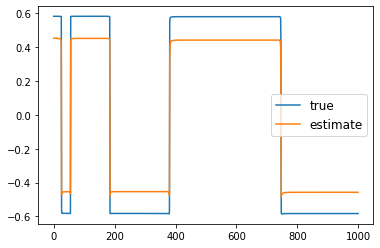

In [244]:
plt.plot(history[0])
plt.plot(history[1])
plt.legend(('true','estimate'), fontsize=12)
plt.show()

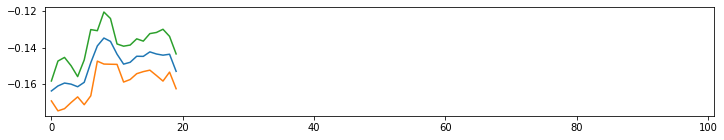

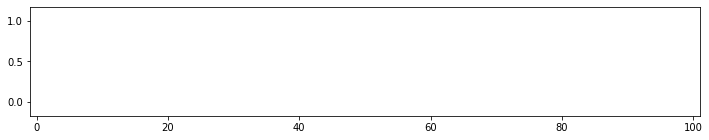

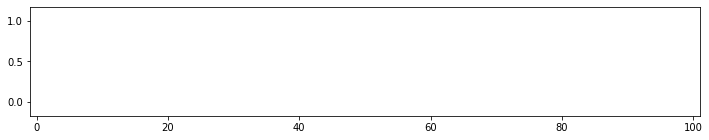

In [245]:
loc = pyro.param('kernel_loc').detach().cpu()
scale = pyro.param('kernel_scale').detach().cpu()
for i in range(3):
    plt.figure(figsize=(12,2))
    plt.plot(loc[i*100:(i+1)*100])
    plt.plot(loc[i*100:(i+1)*100]-scale[i*100:(i+1)*100])
    plt.plot(loc[i*100:(i+1)*100]+scale[i*100:(i+1)*100])
    plt.xlim(-1,101)
    plt.show()

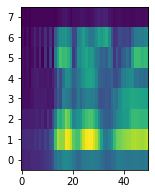

In [206]:
plt.figure(figsize=(3,3))
plt.imshow(X[0][95,:].reshape(-1,window), aspect=8, origin='ll')
plt.show()

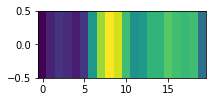

In [246]:
plt.figure(figsize=(3,3))
plt.imshow(pyro.param('kernel_loc').reshape(-1,window).detach().cpu(), aspect=8, origin='ll')
plt.show()

In [247]:
pyro.param('kernel_loc').detach(), pyro.param('memory_loc').detach(), pyro.param('readout_loc').detach()

(tensor([-0.1637, -0.1609, -0.1593, -0.1599, -0.1614, -0.1590, -0.1482, -0.1390,
         -0.1347, -0.1366, -0.1436, -0.1490, -0.1480, -0.1447, -0.1448, -0.1423,
         -0.1435, -0.1441, -0.1436, -0.1529]),
 tensor([0.3259]),
 tensor([0.2483]))

(-0.494118617229904, 3.860443390875746e-32)

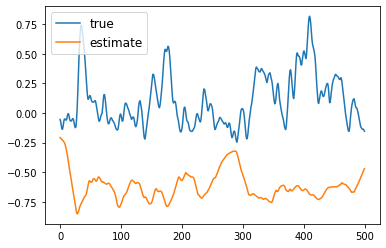

In [248]:
x, y = X_test[1], Y_test[1]
z = model.filter(x)
z = z.detach().cpu()
plt.plot(y[:500])
plt.plot(z[:500])
plt.legend(('true','estimate'), fontsize=12)
sp.stats.pearsonr(y, z)

In [ ]:
# from pyro.contrib.tracking.extended_kalman_filter import EKFState
# from pyro.contrib.tracking.distributions import EKFDistribution
# from pyro.contrib.tracking.dynamic_models import NcvContinuous
# from pyro.contrib.tracking.measurements import PositionMeasurement


# def model(x, y):
#     weight_x1 = pyro.sample('weight_x1', dist.Normal(0, 1))
#     weight_x2 = pyro.sample('weight_x2', dist.Normal(0, 1))
#     bias = pyro.sample('bias', dist.Normal(5, 1))
    
#     with pyro.plate('observations'):
#         target = pyro.sample('obs', dist.Normal(x[:, 0] * weight_x1 + x[:, 1] * weight_x2 + bias, 1), obs=y)

# guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
# optim = pyro.optim.Adam({"lr": 0.005})
# svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=1000)

# def train(num_iterations):
#     pyro.clear_param_store()
#     for j in range(num_iterations):
#         loss = svi.step(x, y)
#         if j % 500 == 0:
#             print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x)))

# train(5000)


# for name, value in pyro.get_param_store().items():
#     print(name, pyro.param(name))

In [ ]:
# Continuous model
ncv = NcvContinuous(dim, 2.0)

# Truth trajectory
xs_truth = torch.zeros(num_frames, dim)
xs_truth[:,:1] = X

In [ ]:
# # Measurements
# measurements = []
# mean = torch.zeros(2)
# # no correlations
# cov = 1e-5 * torch.eye(2)
# with torch.no_grad():
#     # sample independent measurement noise
#     dzs = pyro.sample('dzs', dist.MultivariateNormal(mean, cov).expand((num_frames,)))
#     # compute measurement means
#     zs = xs_truth[:, :2] + dzs

# Measurements
# zs = torch.cat((X, y), 1)
zs = y

In [ ]:
def model(data):
    # a HalfNormal can be used here as well
    R = pyro.sample('pv_cov', dist.HalfCauchy(2e-6)) * torch.eye(2)
    Q = pyro.sample('measurement_cov', dist.HalfCauchy(1e-6)) * torch.eye(1)
    # observe the measurements
    pyro.sample('track_{}'.format(i), EKFDistribution(xs_truth[0], R, ncv, Q, time_steps=num_frames), obs=data)

guide = pyro.infer.autoguide.AutoDelta(model)  # MAP estimation

In [ ]:
optim = pyro.optim.Adam({'lr': 2e-1})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(retain_graph=True))

# pyro.set_rng_seed(0)
pyro.clear_param_store()

for i in range(250):
    loss = svi.step(zs)
    if not i % 10:
        print('loss: ', loss)

In [ ]:
# retrieve states for visualization
R = guide()['pv_cov'] * torch.eye(2)
Q = guide()['measurement_cov'] * torch.eye(1)
ekf_dist = EKFDistribution(xs_truth[0], R, ncv, Q, time_steps=num_frames)
states = ekf_dist.filter_states(zs)

In [ ]:
list(ncv.parameters())

In [ ]:
S = np.stack([_.mean.detach().cpu().numpy() for _ in states])
S.shape

In [ ]:
plt.plot(S);

In [ ]:
np.corrcoef(S.T)[0,1]